#Concatenated Input CNN Model with PSG-Audio
Uses flow and thoracic + abdominal respiratory band channels with Group 5-fold (hold-one-out) validation for the first 50 subjects of [PSG-Audio](https://www.scidb.cn/en/detail?dataSetId=778740145531650048).

If you use the PSG-Audio data in your work please cite the [paper](https://www.nature.com/articles/s41597-021-00977-w).

This is a slightly cleaned up version of our development code supporting the Fusion of Learned Representations for Multimodal Sensor Data Classification paper which is out for review.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2022

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.




# Imports

In [ ]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from datetime import timedelta # for calculating training time
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import urllib.request # to get files from web w/o !wget
from shutil import unpack_archive # to unzip

# Get PSG Audio first 50 subs IR3 X,y,sub arrays using gdrive link share
It is too big to do in one file.

X: https://drive.google.com/file/d/1-91S_9FgWlbrkfFzUoddDKJ2stLcf9Wn/view?usp=share_link

y: https://drive.google.com/file/d/1-Ixhg8R7yIe7WJ3-1D1e2WL9VOaNea19/view?usp=share_link

sub: https://drive.google.com/file/d/1-E29y3fH0Yo0IqxxDmQoYmAkki2t9PDk/view?usp=share_link

In [ ]:
!gdown "1-91S_9FgWlbrkfFzUoddDKJ2stLcf9Wn&confirm=t" # PSG first 50 sub X
!gdown "1-Ixhg8R7yIe7WJ3-1D1e2WL9VOaNea19&confirm=t" # PSG first 50 sub y
!gdown "1-E29y3fH0Yo0IqxxDmQoYmAkki2t9PDk&confirm=t" # PSG first 50 sub sub numbers

Downloading...
From: https://drive.google.com/uc?id=1-91S_9FgWlbrkfFzUoddDKJ2stLcf9Wn&confirm=t
To: /content/X.npy
100% 3.27G/3.27G [00:41<00:00, 78.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Ixhg8R7yIe7WJ3-1D1e2WL9VOaNea19&confirm=t
To: /content/y.npy
100% 136k/136k [00:00<00:00, 97.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-E29y3fH0Yo0IqxxDmQoYmAkki2t9PDk&confirm=t
To: /content/sub.npy
100% 272k/272k [00:00<00:00, 131MB/s]


In [ ]:
# read in the arrays
X = np.load('X.npy')
y = np.load('y.npy')
sub = np.load('sub.npy')
headers = ("Array","shape", "data type")
mydata = [("X:", X.shape, X.dtype),
        ("y:", y.shape, y.dtype),
        ("sub:", sub.shape, sub.dtype)]
print("\n",tabulate(mydata, headers=headers))


 Array    shape              data type
-------  -----------------  -----------
X:       (136175, 500, 12)  float32
y:       (136175, 1)        int8
sub:     (136175, 1)        uint16


# Get flow and two respiratory bands Channels 9, 10, 11


In [ ]:
X = X[:,:,9:12]
headers = ("Array","shape", "data type")
mydata = [("X:", X.shape, X.dtype),
        ("y:", y.shape, y.dtype),
        ("sub:", sub.shape, sub.dtype)]
print("\n",tabulate(mydata, headers=headers))


 Array    shape             data type
-------  ----------------  -----------
X:       (136175, 500, 3)  float32
y:       (136175, 1)       int8
sub:     (136175, 1)       uint16


# Concatenated Input Model

In [ ]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf

def build_1D_CNN(x_train, y_train, num_filters = 100, k1_size=17, k2_size=17, dropout = 0.5, mpool_size = 2):
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
  model = keras.Sequential(
    [
        layers.Input(shape=x_train[0].shape),
        layers.BatchNormalization(scale=False),
        layers.Conv1D(filters=num_filters, kernel_size=k1_size, activation='relu',input_shape=(n_timesteps,n_features)),
        layers.Dropout(dropout),
        layers.Conv1D(filters=num_filters, kernel_size=k2_size, activation='relu'),
        layers.Dropout(dropout),
        layers.MaxPooling1D(pool_size=mpool_size),
        #layers.GlobalAveragePooling1D(),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(n_outputs, activation='softmax')
        ])
  return model 

def train_1D_CNN(model,x_train, y_train, x_test, y_test,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    MAX_EPOCHS = 200): # Max number run unless earlystopping callback fires
    # increasing dropout to 0.8 and higher requires more than 100 epochs
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=20)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        x_train,y_train,
        batch_size = BATCH_SIZE,
        epochs=MAX_EPOCHS,
        callbacks=[callback],
        validation_data=(x_test,y_test),
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model

model = build_1D_CNN(X, y)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 500, 3)           9         
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 484, 100)          5200      
                                                                 
 dropout_2 (Dropout)         (None, 484, 100)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 468, 100)          170100    
                                                                 
 dropout_3 (Dropout)         (None, 468, 100)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 234, 100)         0         
 1D)                                                  

## Run a stratified 5-fold group-based cross validation

Fold 0:
Epoch 1/200
3336/3336 [==============================] - 43s 11ms/step - loss: 0.3417 - accuracy: 0.8566 - val_loss: 0.3695 - val_accuracy: 0.8541
Epoch 2/200
3336/3336 [==============================] - 32s 9ms/step - loss: 0.2918 - accuracy: 0.8825 - val_loss: 0.3543 - val_accuracy: 0.8718
Epoch 3/200
3336/3336 [==============================] - 33s 10ms/step - loss: 0.2720 - accuracy: 0.8928 - val_loss: 0.3679 - val_accuracy: 0.8582
Epoch 4/200
3336/3336 [==============================] - 33s 10ms/step - loss: 0.2629 - accuracy: 0.8973 - val_loss: 0.2864 - val_accuracy: 0.8967
Epoch 5/200
3336/3336 [==============================] - 32s 10ms/step - loss: 0.2599 - accuracy: 0.8988 - val_loss: 0.2961 - val_accuracy: 0.8929
Epoch 6/200
3336/3336 [==============================] - 31s 9ms/step - loss: 0.2546 - accuracy: 0.9000 - val_loss: 0.3156 - val_accuracy: 0.8912
Epoch 7/200
3336/3336 [==============================] - 31s 9ms/step - loss: 0.2520 - accuracy: 0.9017 - val_lo

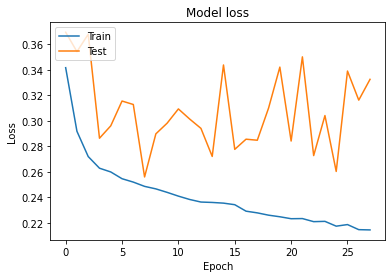

Fold 1:
Epoch 1/200
3495/3495 [==============================] - 33s 9ms/step - loss: 0.3245 - accuracy: 0.8650 - val_loss: 0.4554 - val_accuracy: 0.8192
Epoch 2/200
3495/3495 [==============================] - 32s 9ms/step - loss: 0.3005 - accuracy: 0.8795 - val_loss: 0.4111 - val_accuracy: 0.8266
Epoch 3/200
3495/3495 [==============================] - 32s 9ms/step - loss: 0.2718 - accuracy: 0.8931 - val_loss: 0.3816 - val_accuracy: 0.8383
Epoch 4/200
3495/3495 [==============================] - 32s 9ms/step - loss: 0.2583 - accuracy: 0.8993 - val_loss: 0.3745 - val_accuracy: 0.8417
Epoch 5/200
3495/3495 [==============================] - 32s 9ms/step - loss: 0.2494 - accuracy: 0.9020 - val_loss: 0.3927 - val_accuracy: 0.8397
Epoch 6/200
3495/3495 [==============================] - 32s 9ms/step - loss: 0.2417 - accuracy: 0.9060 - val_loss: 0.3256 - val_accuracy: 0.8763
Epoch 7/200
3495/3495 [==============================] - 32s 9ms/step - loss: 0.2358 - accuracy: 0.9079 - val_loss: 

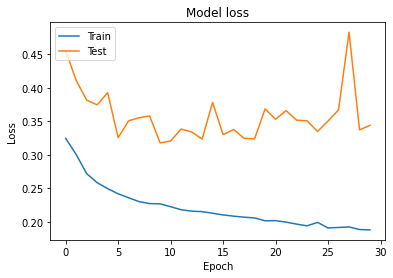

Fold 2:
Epoch 1/200
3440/3440 [==============================] - 32s 9ms/step - loss: 0.3296 - accuracy: 0.8658 - val_loss: 0.2992 - val_accuracy: 0.8808
Epoch 2/200
3440/3440 [==============================] - 31s 9ms/step - loss: 0.2753 - accuracy: 0.8920 - val_loss: 0.2984 - val_accuracy: 0.8841
Epoch 3/200
3440/3440 [==============================] - 34s 10ms/step - loss: 0.2584 - accuracy: 0.8995 - val_loss: 0.2776 - val_accuracy: 0.8964
Epoch 4/200
3440/3440 [==============================] - 32s 9ms/step - loss: 0.2498 - accuracy: 0.9036 - val_loss: 0.2541 - val_accuracy: 0.8978
Epoch 5/200
3440/3440 [==============================] - 31s 9ms/step - loss: 0.2459 - accuracy: 0.9054 - val_loss: 0.2623 - val_accuracy: 0.8898
Epoch 6/200
3440/3440 [==============================] - 31s 9ms/step - loss: 0.2408 - accuracy: 0.9074 - val_loss: 0.2559 - val_accuracy: 0.8985
Epoch 7/200
3440/3440 [==============================] - 31s 9ms/step - loss: 0.2362 - accuracy: 0.9089 - val_loss:

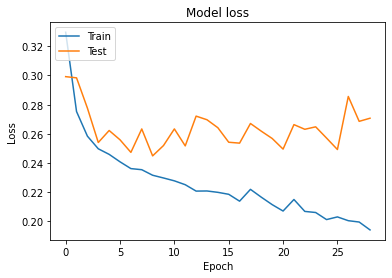

Fold 3:
Epoch 1/200
3381/3381 [==============================] - 35s 10ms/step - loss: 0.3332 - accuracy: 0.8619 - val_loss: 0.3425 - val_accuracy: 0.8669
Epoch 2/200
3381/3381 [==============================] - 31s 9ms/step - loss: 0.3077 - accuracy: 0.8750 - val_loss: 0.3553 - val_accuracy: 0.8713
Epoch 3/200
3381/3381 [==============================] - 34s 10ms/step - loss: 0.2869 - accuracy: 0.8868 - val_loss: 0.2826 - val_accuracy: 0.9003
Epoch 4/200
3381/3381 [==============================] - 34s 10ms/step - loss: 0.2679 - accuracy: 0.8962 - val_loss: 0.2744 - val_accuracy: 0.9020
Epoch 5/200
3381/3381 [==============================] - 34s 10ms/step - loss: 0.2598 - accuracy: 0.8987 - val_loss: 0.3281 - val_accuracy: 0.8809
Epoch 6/200
3381/3381 [==============================] - 34s 10ms/step - loss: 0.2544 - accuracy: 0.9015 - val_loss: 0.2670 - val_accuracy: 0.9020
Epoch 7/200
3381/3381 [==============================] - 31s 9ms/step - loss: 0.2499 - accuracy: 0.9032 - val_l

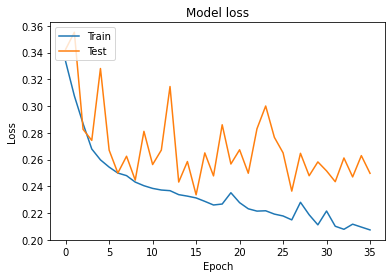

Fold 4:
Epoch 1/200
3371/3371 [==============================] - 31s 9ms/step - loss: 0.3307 - accuracy: 0.8642 - val_loss: 0.4934 - val_accuracy: 0.7800
Epoch 2/200
3371/3371 [==============================] - 32s 10ms/step - loss: 0.2821 - accuracy: 0.8895 - val_loss: 0.4316 - val_accuracy: 0.8171
Epoch 3/200
3371/3371 [==============================] - 32s 10ms/step - loss: 0.2594 - accuracy: 0.8997 - val_loss: 0.4303 - val_accuracy: 0.8224
Epoch 4/200
3371/3371 [==============================] - 32s 10ms/step - loss: 0.2506 - accuracy: 0.9030 - val_loss: 0.3256 - val_accuracy: 0.8784
Epoch 5/200
3371/3371 [==============================] - 32s 10ms/step - loss: 0.2447 - accuracy: 0.9055 - val_loss: 0.3511 - val_accuracy: 0.8649
Epoch 6/200
3371/3371 [==============================] - 30s 9ms/step - loss: 0.2406 - accuracy: 0.9067 - val_loss: 0.3360 - val_accuracy: 0.8737
Epoch 7/200
3371/3371 [==============================] - 30s 9ms/step - loss: 0.2332 - accuracy: 0.9110 - val_lo

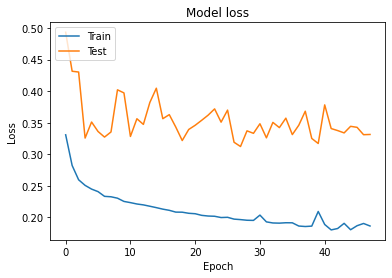

------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 0.3325921893119812 - Accuracy: 88.13380599021912%
> Fold 1 - Accuracy: 88.13380599021912%
> Fold 2 - Loss: 0.34392249584198 - Accuracy: 86.53356432914734%
> Fold 2 - Accuracy: 86.53356432914734%
> Fold 3 - Loss: 0.27071505784988403 - Accuracy: 89.97662663459778%
> Fold 3 - Accuracy: 89.97662663459778%
> Fold 4 - Loss: 0.24971464276313782 - Accuracy: 90.909743309021%
> Fold 4 - Accuracy: 90.909743309021%
> Fold 5 - Loss: 0.3313123881816864 - Accuracy: 87.89880871772766%
> Fold 5 - Accuracy: 87.89880871772766%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 88.69050979614258 (+- 1.5600139345227018)
------------------------------------------------------------------------


In [ ]:
# original source NNCLR_Multi_CNN_Funct_classifier_TWristAR_and_UE4W_4.ipynb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder

import sys

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
y_pred_per_fold = []
y_test_per_fold = []

skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(X, y, groups=sub)):
    print(f"Fold {i}:")

    x_train = X[train_index]
    x_test = X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    enc = OneHotEncoder(categories='auto', sparse=False)
    y_train = enc.fit_transform(y_train)
    y_test = enc.fit_transform(y_test)

    model = build_1D_CNN(x_train, y_train)
    history, model = train_1D_CNN(model, x_train, y_train,
                                          x_test, y_test)  
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1] 

    acc_per_fold.append(val_acc * 100)
    loss_per_fold.append(val_loss)

    # Generate predictions
    y_pred = model.predict(x_test, verbose = 0)

    y_pred = np.argmax(y_pred, axis=1)
    y_pred_per_fold.append(y_pred)
    y_test_per_fold.append(np.argmax(y_test, axis=1))

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
#     print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
#print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Confusion matrix, without normalization
[[94582  7299]
 [ 8058 26236]]


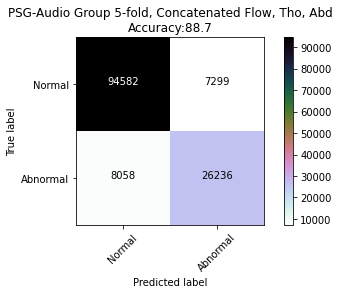

In [ ]:
# == Confusion matrix ==
from sklearn.metrics import confusion_matrix
import itertools

y_pred = np.concatenate(y_pred_per_fold)
y_test = np.concatenate(y_test_per_fold)

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
    
        print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
title = 'PSG-Audio Group 5-fold, Concatenated Flow, Tho, Abd\n'
title += 'Accuracy:{0:.1f}'.format(np.mean(acc_per_fold))
plot_confusion_matrix(cm, classes=['Normal','Abnormal'], title=title, cmap='cubehelix_r')